# 06 - Error Analysis

## Import and config

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
confusion_matrix, classification_report, roc_curve, roc_auc_score,
precision_recall_curve
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import shap
import umap

from sklearn.ensemble import IsolationForest

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load test data, model and compute predictions

In [3]:
# Load tuned XGBoost model from pickle
tuned_model_filename = "xgb_pdm_finetuned.pkl"
model = joblib.load(tuned_model_filename)   # use `model` to match the rest of the notebook
threshold = 0.51

print("Loaded tuned model from:", tuned_model_filename)

# Path to engineered feature matrix
test_path = "test_vehicle_features.csv"
df_test = pd.read_csv(test_path)

print("Test shape:", df_test.shape)

VEHICLE_COL = "vehicle_id"
TARGET_COL = "in_study_repair"

# Features are all columns except vehicle id + target
feature_cols = [c for c in df_test.columns if c not in [VEHICLE_COL, TARGET_COL]]

X_test = df_test[feature_cols]
y_true = df_test[TARGET_COL].astype(int)

# Model predictions
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# Build error-analysis frame
df_err = df_test[[VEHICLE_COL]].copy()     # keep vehicle_id for inspection
df_err = pd.concat([df_err, X_test], axis=1)
df_err["y_true"] = y_true
df_err["y_proba"] = y_proba
df_err["y_pred"] = y_pred

df_err["error_type"] = np.select(
    [
        (y_pred == 1) & (y_true == 0),   # predicted failure, actually healthy
        (y_pred == 0) & (y_true == 1),   # predicted healthy, actually failure
    ],
    ["FP", "FN"],
    default="Correct",
)

Loaded tuned model from: xgb_pdm_finetuned.pkl
Test shape: (5045, 577)


## Confusion matrix + summary

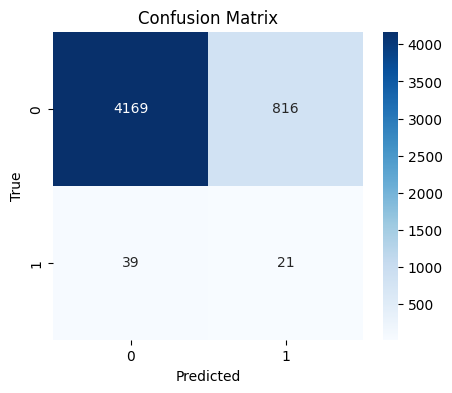

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_true, y_pred)

## Probability distribution for error types

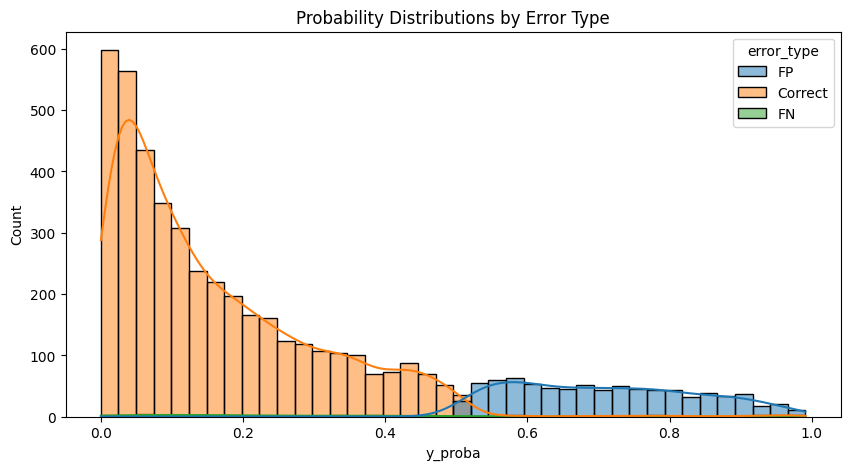

In [11]:
def plot_probability_distributions(df_err):
    plt.figure(figsize=(10,5))
    sns.histplot(data=df_err, x="y_proba", hue="error_type", kde=True, bins=40)
    plt.title("Probability Distributions by Error Type")
    plt.show()

plot_probability_distributions(df_err)

### Analysis
**1. Correct predictions dominate and cluster at low probabilities**

The huge orange block at the left (0.0–0.2) is expected:
* The dataset is heavily imbalanced.
* Most vehicles are healthy.
* The model assigns low probabilities (0–0.3) to these healthy units. These are true negatives, and this is exactly where a classifier with modest skill would place them.

**2. False positives cluster around moderate/high probabilities (0.5–1.0)**

The blue bars are mostly between 0.55 and 0.95—which is after thresholding (τ=0.51) why they become “predicted failures.”

This tells us:
* These vehicles have patterns that look somewhat failure-like, even though they are labeled healthy.
* Either:
    * The model is overreacting to certain signals (noise or anomalous sensors), or
    * These vehicles exhibit behaviors that resemble historical failure patterns.
FPs are not randomly scattered; they form a distinct band → the model is systematically triggered by something.

This is a root cause worth exploring with SHAP and PCA.

**3. False negatives are extremely rare and near 0.4–0.5**

The FN curve is hard to see - that’s because:

* Failures are extremely rare in the dataset.
* False negatives are even rarer (the model labels most failures correctly).
* The FN distribution appears close to 0.4–0.6, i.e. borderline probability.

This pattern tells us:
*  The model does detect many failures by assigning higher probabilities.
* But the missed failures are:
    * Not obvious failures (in available sensors)
    * Feature-engineered representation may have “washed out” some signals
    * These vehicles look similar to healthy ones, causing the proba to remain moderate.

This supports the idea that the dataset’s failure signature is subtle.


<Axes: xlabel='y_proba', ylabel='Count'>

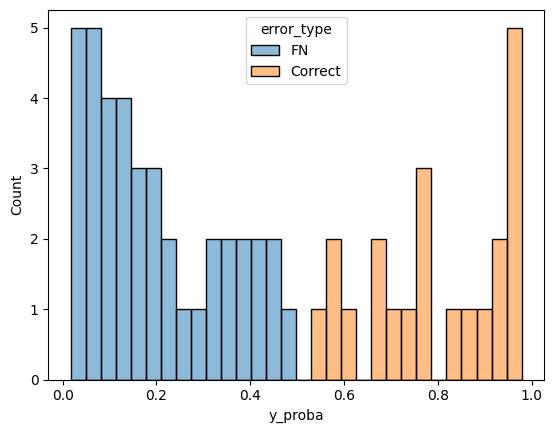

In [34]:
# plot probability only for positives
sns.histplot(df_err[df_err.y_true==1], x="y_proba", hue="error_type", bins=30) # select only actual failures (true positive class); 
# inside that subset, the error_type column still distinguishes between TP and FN

### Analysis
**1. Most actual failures get very high predicted probabilities (0.7–1.0)**

These are Correct (true positives).

This is good:

The model recognizes many genuine failure cases confidently.

**2. False negatives cluster around 0.0–0.5**

These are genuine failures that “look healthy” from the model’s perspective.

This tells us that:
* The feature representation doesn’t make these failures stand out.
* These vehicles have sensor/feature profiles similar to healthy ones.
* Their failure signatures are weak, atypical, subtle, or noisy.
* Possible label noise: maybe they were repaired but not truly failing in the data window.

## PCA visualization of FP/FN clusters
* PCA compresses hundreds of engineered features into 2 dimensions (PC1, PC2).

* This gives a coarse overview of the geometry of the dataset.

* BUT PCA cannot preserve all structure, especially in highly non-linear data such as sensor-derived features.

So we should expect overlap - but patterns of clustering or separation still matter.

Using 1621 samples out of 5045 for PCA (dropped 3424 rows with NaNs).


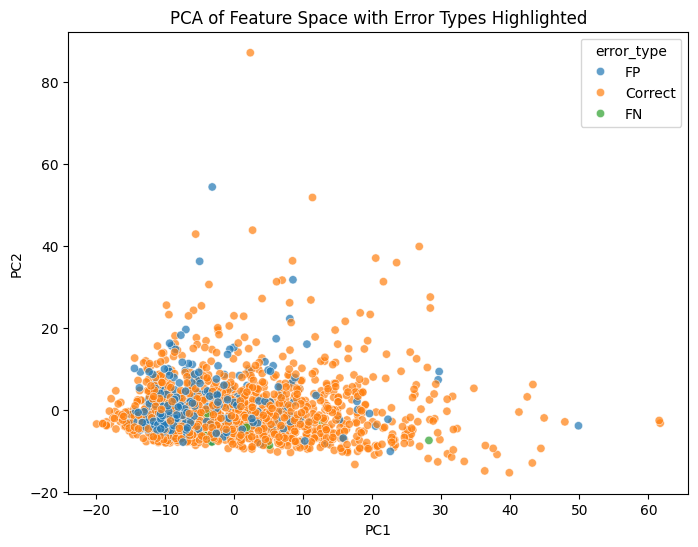

In [14]:
# Drop rows with NaNs
def plot_pca(df_err, feature_cols):
    X = df_err[feature_cols].copy()
    X = X.replace([np.inf, -np.inf], np.nan)

    # keep only rows that are completely finite
    mask = X.notna().all(axis=1)
    X_clean = X[mask]
    err_types_clean = df_err.loc[mask, "error_type"]

    print(f"Using {X_clean.shape[0]} samples out of {X.shape[0]} for PCA (dropped {(~mask).sum()} rows with NaNs).")

    X_scaled = StandardScaler().fit_transform(X_clean)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    df_plot = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "error_type": err_types_clean.values
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="error_type", alpha=0.7)
    plt.title("PCA of Feature Space with Error Types Highlighted")
    plt.show()

plot_pca(df_err, feature_cols)

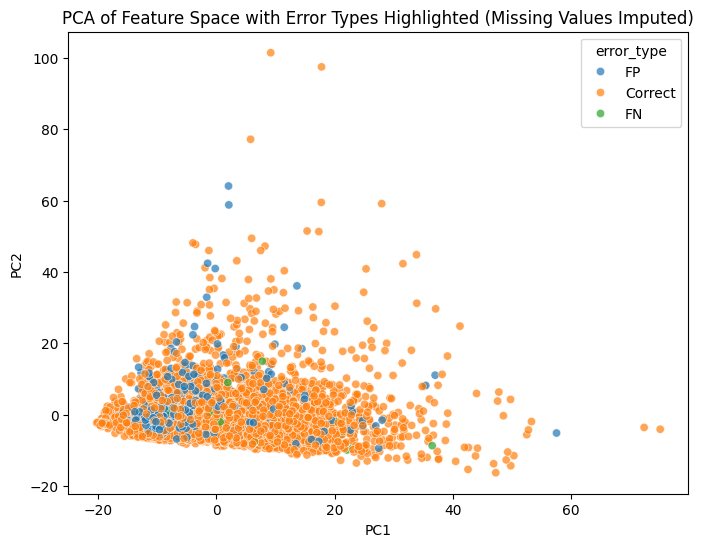

In [36]:
# impute missing values
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def plot_pca(df_err, feature_cols):
    # 1) Extract features
    X = df_err[feature_cols].copy()

    # 2) Replace inf/-inf with NaN (just in case)
    X = X.replace([np.inf, -np.inf], np.nan)

    # 3) Impute missing values (median is robust)
    imputer = SimpleImputer(strategy="median")
    X_imputed = imputer.fit_transform(X)

    # 4) Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # 5) PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # 6) Build plot dataframe
    df_plot = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "error_type": df_err["error_type"].values
    })

    # 7) Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_plot,
        x="PC1",
        y="PC2",
        hue="error_type",
        alpha=0.7
    )
    plt.title("PCA of Feature Space with Error Types Highlighted (Missing Values Imputed)")
    plt.show()

plot_pca(df_err, feature_cols)

### Observations based on PCA
**1. The vast majority of points are “Correct” (orange)**

This reflects the extreme class imbalance:

* Most trucks are healthy.

* Most predictions are correct (true negatives).

This is expected.

**2. False positives (blue) are scattered but not random**

The FPs appear mixed in with normal healthy trucks — no distinct cluster.
But they are:

* More common in the upper half of the PCA plane (higher PC2)

* Some appear in outer regions (e.g., top-right)

What this suggests:

**FP trucks tend to have unusual feature profiles**

They are “corner cases” in feature space but do not form a tight cluster.

The model is reacting to **specific engineered signals** (slopes, entropies, counters)
These may mimic failure-like patterns even in healthy trucks.

These FPs are likely due to:

* rare operating conditions

* noisy sensor channels

* aggressive thresholding

* or mislabeled “healthy” cases

FP distribution being spread out indicates the model is over-sensitive to certain feature directions.

**3. False negatives (green) are very few and sit inside the healthy cluster**

This is an important finding:

**FN points lie completely within the large orange (Correct) cloud.**

Meaning:

* These failures look extremely similar to healthy trucks in the engineered feature space.

* The model reasonably believes they are healthy — the failure signal does not stand out.

* Their failure modes may be subtle or not well captured by:

    * histogram entropy features

    * counter trends

    * slope statistics

This aligns with earlier plots showing FN probabilities clustering around 0.1–0.4.

**→ These are “hard failures” with weak or noisy precursors.**


### UMAP Visualization

UMAP is a non-linear manifold learner and usually reveals structure PCA hides.

UMAP preserves:

* local neighborhoods
* cluster connectivity
* non-linear relations

PCA only preserves linear variance.

So UMAP shows us something deeper:

> There is a non-linear submanifold where the model gets confused.

That’s crucial for guiding improvements.

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


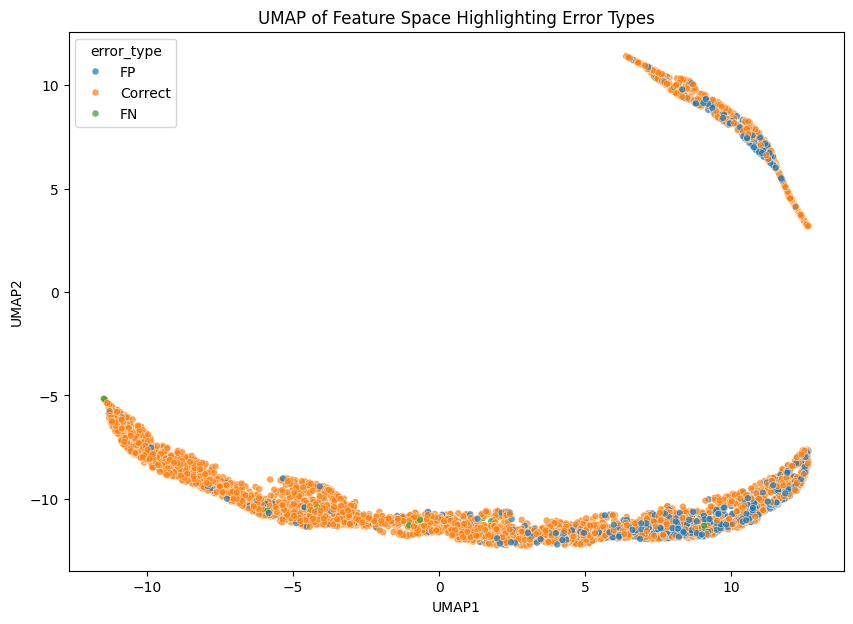

In [4]:
# Prepare feature matrix and impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(df_err[feature_cols])

# Run UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_umap = reducer.fit_transform(X_imputed)

# Prepare plot dataframe
df_umap = pd.DataFrame({
    "UMAP1": X_umap[:, 0],
    "UMAP2": X_umap[:, 1],
    "error_type": df_err["error_type"].values
})

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_umap,
    x="UMAP1",
    y="UMAP2",
    hue="error_type",
    alpha=0.7,
    s=25
)
plt.title("UMAP of Feature Space Highlighting Error Types")
plt.show()

#### Interpreting the UMAP plot

UMAP squeezed the high-dimensional feature space into 2D (UMAP1, UMAP2).

The points form two long curved manifolds:

* a large “arc” at the bottom

* a smaller arc at the top

**a) Two main operating regimes**

Those two arcs likely correspond to different operating regimes / subpopulations in your engineered feature space:

* Different vehicle types or configurations
* Different usage patterns (duty cycles, load profiles)
* Or sensor combinations behaving differently

**b) False positives (blue) are embedded in these manifolds, not forming their own island**

In the lower arc, false positives (blue) tend to cluster toward the right-hand side (higher UMAP1 values).

Even though UMAP1 is not a literal “sensor axis,” this pattern is not random.
UMAP is preserving the structure of the high-dimensional feature space, so:

> A systematic shift in UMAP1 corresponds to a consistent shift in certain engineered features.

This means those false positives share some common high-dimensional characteristics.

**c) False negatives (green) are rare and lie deep inside orange clouds**

UMAP reveals that false positives are not randomly scattered but tend to concentrate in the right-hand region of the lower manifold. This suggests a systematic pattern in the engineered features that is consistently interpreted by the model as failure-like behavior. The rightward region likely corresponds to vehicles exhibiting noisier or higher-variance sensor patterns, elevated entropy features, or pronounced counter trends. These characteristics mimic actual failure signatures, causing the model to predict failure incorrectly. This indicates an over-sensitivity of the model in this subspace and points to specific feature groups for refinement (e.g., entropy normalization, counter trend smoothing, or per-regime thresholds).


### Cluster Analysis on False Positives

In [6]:
# Extract FP subset:
df_fp = df_err[df_err.error_type == "FP"]
X_fp = df_fp[feature_cols]

# Impute (required for k-means / DBSCAN)
X_fp_imputed = imputer.fit_transform(X_fp)

#### Option A – KMeans clustering

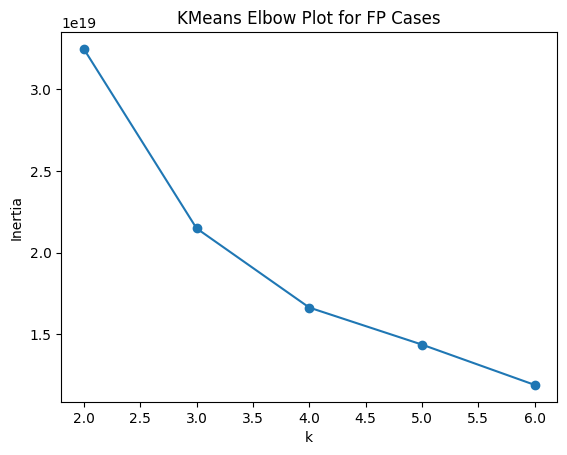

In [7]:
from sklearn.cluster import KMeans

# Try k=2..6 and check inertia (elbow method)
inertias = []
Ks = range(2, 7)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_fp_imputed)
    inertias.append(km.inertia_)

plt.plot(Ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("KMeans Elbow Plot for FP Cases")
plt.show()

Choose a reasonable k (start with 3):

In [9]:
km = KMeans(n_clusters=3, random_state=42)
fp_labels = km.fit_predict(X_fp_imputed)

df_fp["cluster"] = fp_labels
df_fp.head()

/tmp/ipykernel_3084/1213365535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp["cluster"] = fp_labels


,vehicle_id,171_0_first,171_0_last,171_0_delta,171_0_mean,171_0_std,171_0_slope,171_0_r2,666_0_first,666_0_last,...,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8,y_true,y_proba,y_pred,error_type,cluster
0,1,94410.0,5451915.0,5357505.0,3.093498e+06,1.483355e+06,24280.237220,0.999505,7982.0,645170.0,...,0,0,0,0,0,0,0.720728,1,FP,0
1,6,33150.0,1374270.0,1341120.0,7.599548e+05,3.634452e+05,12693.412919,0.962648,871.0,193638.0,...,0,0,0,0,0,0,0.863769,1,FP,1
11,46,7950.0,7244070.0,7236120.0,2.737610e+06,2.399706e+06,34876.968449,0.985128,39.0,477975.0,...,0,0,0,0,0,0,0.579181,1,FP,0
33,198,23490.0,746085.0,722595.0,4.068058e+05,2.277445e+05,8731.210193,0.998322,169.0,2446.0,...,0,0,0,0,0,0,0.861824,1,FP,1
40,238,51045.0,3456015.0,3404970.0,1.337369e+06,1.060672e+06,21860.154799,0.995151,6864.0,456143.0,...,0,0,0,0,0,0,0.895306,1,FP,0


Plot FP clusters on UMAP:

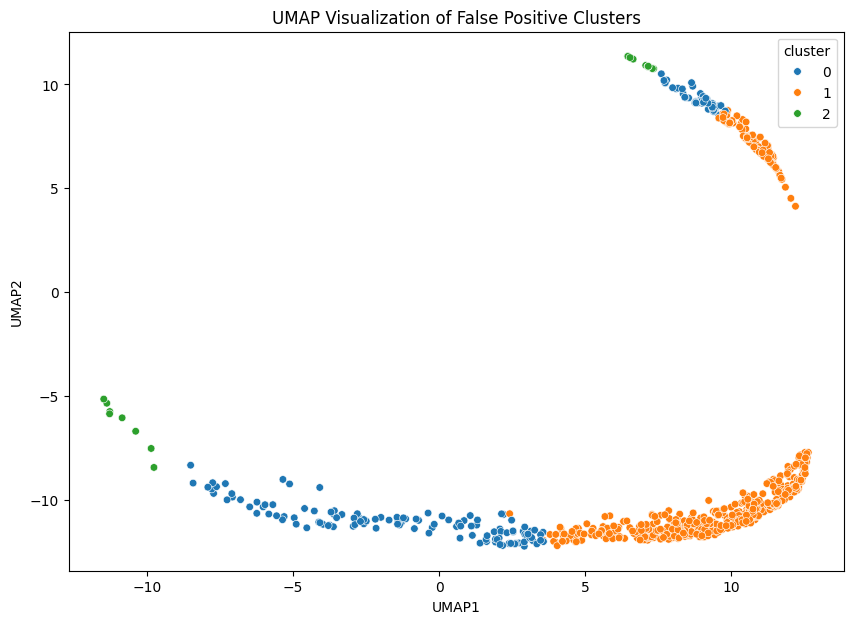

In [10]:
df_umap_fp = df_umap.loc[df_fp.index].copy()
df_umap_fp["cluster"] = fp_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_umap_fp,
    x="UMAP1",
    y="UMAP2",
    hue="cluster",
    palette="tab10",
    s=30
)
plt.title("UMAP Visualization of False Positive Clusters")
plt.show()

The result:

* **Cluster 0 (blue): Left & lower arc**

    The “main” FP type, driven by a consistent pattern → most promising target for feature engineering improvements.

* **Cluster 1 (orange): Right arc**
    
    More diffuse, representing borderline signals and noise.

* **Cluster 2 (green): A tiny group on both arcs’ ends**

    Small but significant: these trucks are fundamentally different.

In [18]:
# --- Step 1: Compute cluster-level feature means for False Positives ---

df_fp_clustered = df_fp.copy()  # already contains 'cluster' from KMeans

# Compute mean per cluster
cluster_means = df_fp_clustered.groupby("cluster")[feature_cols].mean()

print("Cluster means shape:", cluster_means.shape)
cluster_means.head()

Cluster means shape: (3, 575)


,171_0_first,171_0_last,171_0_delta,171_0_mean,171_0_std,171_0_slope,171_0_r2,666_0_first,666_0_last,666_0_delta,...,Spec_6_Cat8,Spec_6_Cat9,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8
cluster,,,,,,,,,,,,,,,,,,,,,
0,128768.983051,4.388459e+06,4.259690e+06,2.308196e+06,1.291496e+06,27652.063495,0.996431,10813.717514,415185.112994,404371.395480,...,0.0,0.0,0.457627,0.039548,0.00000,0.107345,0.000000,0.096045,0.101695,0.00000
1,105860.241546,2.097355e+06,1.991494e+06,1.118419e+06,6.286939e+05,23005.239013,0.994150,7929.623188,163377.795491,155448.172303,...,0.0,0.0,0.095008,0.028986,0.00161,0.297907,0.045089,0.117552,0.152979,0.00161
2,132827.500000,8.547818e+06,8.414990e+06,4.682663e+06,2.570431e+06,44161.827322,0.998293,13000.388889,806811.388889,793811.000000,...,0.0,0.0,0.388889,0.055556,0.00000,0.166667,0.000000,0.111111,0.000000,0.00000


In [19]:
# Highlight features that vary the most across clusters
# This is effectively a feature-variance-across-clusters metric:
cluster_feature_variation = cluster_means.var(axis=0).sort_values(ascending=False)

cluster_feature_variation.head(20)
# These features are the most likely to explain why clusters separate.

158_total_max     6.883593e+16
835_0_last        4.380483e+16
835_0_delta       4.311359e+16
272_total_max     4.249618e+16
158_total_mean    2.152687e+16
167_total_max     2.044619e+16
272_3_max         1.763241e+16
397_total_max     1.720911e+16
427_0_last        1.435093e+16
427_0_delta       1.421864e+16
835_0_mean        1.375320e+16
272_total_mean    1.329015e+16
158_2_max         1.118246e+16
167_total_mean    6.552199e+15
158_total_std     6.196494e+15
167_5_max         5.928317e+15
272_3_mean        5.503426e+15
397_total_mean    5.381791e+15
427_0_mean        4.384711e+15
835_0_std         3.910038e+15
dtype: float64

**Key takeaway**:

> The FP clusters differ most strongly on features like:
> * _total_max
> * _total_mean
> * _std
> * _delta
> * _last

These are summary statistics of time-series channels, meaning:

* some sensors have very different magnitudes across clusters,

* some clusters have much larger total activity,

* others have sharp deltas or end values (last) that differ.

* This already suggests that FP clusters correspond to different physical regimes.

In [21]:
# Direct comparison: Cluster 1 (right-arc FPs) vs Cluster 0 (left/middle FPs)
cluster1 = cluster_means.loc[1]
cluster0 = cluster_means.loc[0]

diff_1_vs_0 = (cluster1 - cluster0).sort_values(ascending=False)
diff_1_vs_0.head(20)

272_5_min            5577.626655
459_centroid_min        0.259860
Spec_2_Cat1             0.199541
Spec_7_Cat4             0.190562
459_centroid_max        0.180380
Spec_1_Cat1             0.153634
Spec_6_Cat1             0.146920
459_centroid_mean       0.135951
272_centroid_min        0.074732
Spec_7_Cat7             0.051284
Spec_7_Cat5             0.045089
272_centroid_max        0.037235
Spec_3_Cat3             0.030541
459_centroid_std        0.029698
397_centroid_std        0.025462
Spec_1_Cat7             0.021698
Spec_7_Cat6             0.021507
272_centroid_mean       0.019446
272_centroid_std        0.017294
Spec_6_Cat3             0.016867
dtype: float64

1️⃣ 272_5_min

* This is the minimum value of sensor-channel group 272, subfeature 5.

*  The min being much higher in Cluster 1 suggests:

> “Cluster 1 trucks never go low on this signal — they operate consistently at a high baseline.”

This is typical of high-load or high-temperature systems.

2️⃣ 459_centroid_min, 459_centroid_max, 459_centroid_mean

* These are histogram-based features.

* A centroid is the weighted average of the histogram:
→ indicates the “typical value” of that sensor channel.

Cluster 1 having higher centroids means:

> “Sensor 459 is systematically shifted upward in Cluster 1 FPs.”

Again: increased load, pressure, temperature, vibration, or usage cycle.

**Summary for Cluster 1:**

Cluster 1 represents trucks with systematically elevated sensor baselines across multiple channels.
This is why the model thinks they look like failures.

This matches the UMAP observation that Cluster 1 sits on the right-hand arc, a separate operational regime.

In [22]:
# And in the opposite direction:
diff_0_vs_1 = (cluster0 - cluster1).sort_values(ascending=False)
diff_0_vs_1.head(20)

158_total_max     1.576441e+08
835_0_last        1.285108e+08
835_0_delta       1.270038e+08
272_total_max     1.238671e+08
167_total_max     8.545556e+07
427_0_last        8.386021e+07
427_0_delta       8.293996e+07
158_total_mean    8.164217e+07
397_total_max     7.882947e+07
272_4_max         6.737348e+07
835_0_mean        6.655355e+07
272_total_mean    6.408647e+07
158_2_max         5.304550e+07
167_5_max         5.048708e+07
158_total_std     4.570506e+07
167_total_mean    4.436889e+07
427_0_mean        4.360229e+07
272_3_max         4.154967e+07
397_total_mean    4.082314e+07
158_1_max         3.957737e+07
dtype: float64

**Interpretation**

* Cluster 0 trucks have:

* very high total_max on multiple channels (158, 272, 167, 397, 427, 835)

* higher final values (_last)

* larger spikes (_delta)

* higher dispersion (_std)

This suggests a different operational pattern:

> Cluster 0 trucks experience large excursions or spikes in certain sensors, instead of sustained high values.

Sustained high values → Cluster 1
Large occasional spikes → Cluster 0

Both can appear “failure-like”, but in different ways.

**We have identified 2 principal FP modes**

Cluster 1 (right arc) = “High baseline sensors” FP group

Where:

* sensors operate consistently at high values

* trends or centroids are elevated

* looks like a degradation plateau

Cluster 0 = “Spiky or noisy sensors” FP group

Where:

* extreme max values

* large final-value deltas

* high variance patterns

* looks like sudden bursts or anomalies

Cluster 2 = very small outlier group

Likely:

* rare behavior patterns

* sensors with extremely unusual distributions

* missing-data artifacts or mislabeled samples

**We could proceed as follows**

**STEP A - Visualize a few raw time-series or distributions**

Even if uneven, plotting raw traces for sensors 158, 272, 835, 459 across clusters would be powerful.

**STEP B - Confirm these patterns with SHAP per cluster**

You’re already set up for this - just rerun after fixing the missing explainer.

Expect signatures like:

* Cluster 1 SHAP → big positive contributions from centroid/max/mean

* Cluster 0 SHAP → big positive contributions from delta/std/max

**STEP C - Build a cluster-level summary table**

To include in the portfolio.


##### Cohen's d effect size
Cohen’s d is a standardized measure of the difference between two means. It expresses the difference in units of the pooled standard deviation.

$$
d = \frac{\mu_{\mathrm{FP}} - \mu_{\mathrm{FN}}}{\sigma_{\mathrm{pooled}}}
$$

$$
\sigma_{\mathrm{pooled}} = \sqrt{\frac{\sigma_{\mathrm{FP}}^{2} + \sigma_{\mathrm{FN}}^{2}}{2}}
$$

**Interpretation**

It tells you how many standard deviations apart the two groups are.

* d=0: the groups have identical means
* d>0: FP has a higher mean than FN
* d<0: FN has a higher mean than FP

Magnitude: the absolute value ∣d∣ reflects the effect size.

Conventional interpretation (Cohen, 1988)

These are rough guidelines—not universal rules:

|          |     Cohen’s d     | Interpretation                  |
| -------: | :---------------: | :------------------------------ |
|  **0.2** |    Small effect   | Means differ by 0.2 SD          |
|  **0.5** |   Medium effect   | Means differ by 0.5 SD          |
|  **0.8** |    Large effect   | Means differ by 0.8 SD          |
| **1.2+** | Very large effect | Means differ by over a full SD  |
| **2.0+** |    Huge effect    | Means differ by two SDs or more |


In [25]:
# --- Step 2: Cohen's d effect size for cluster comparisons ---

def cohens_d(group_a, group_b):
    """Compute Cohen's d."""
    mean_a = group_a.mean()
    mean_b = group_b.mean()
    var_a = group_a.var()
    var_b = group_b.var()
    pooled_std = np.sqrt((var_a + var_b) / 2)
    if pooled_std == 0:
        return 0
    return (mean_a - mean_b) / pooled_std

# Compare cluster 1 vs 0
effect_1_vs_0 = {}
for f in feature_cols:
    effect_1_vs_0[f] = cohens_d(
        df_fp_clustered[df_fp_clustered.cluster == 1][f],
        df_fp_clustered[df_fp_clustered.cluster == 0][f]
    )

effect_1_vs_0 = pd.Series(effect_1_vs_0).sort_values(ascending=False)
effect_1_vs_0.head(20)

Spec_7_Cat4         0.487291
Spec_2_Cat1         0.406628
Spec_6_Cat1         0.344396
Spec_1_Cat1         0.310889
Spec_7_Cat5         0.307055
Spec_1_Cat14        0.161428
Spec_3_Cat3         0.160288
Spec_7_Cat7         0.154048
Spec_5_Cat4         0.139574
Spec_6_Cat5         0.133594
Spec_1_Cat7         0.132087
459_centroid_min    0.127280
459_centroid_max    0.113711
272_centroid_std    0.111434
291_centroid_std    0.109934
459_centroid_std    0.107894
Spec_1_Cat5         0.107259
Spec_6_Cat3         0.107235
167_centroid_std    0.102794
272_centroid_min    0.102712
dtype: float64

➤ Conclusion (1 vs 0)

Cluster 1 differs from cluster 0, but not strongly.
Only a handful of features show moderate separation, and even those are still in the small–medium range.

This means clusters 0 and 1 are somewhat similar, with mild but consistent differences.

In [26]:
# Repeat for Cluster 1 vs Cluster 2:
effect_1_vs_2 = {}
for f in feature_cols:
    effect_1_vs_2[f] = cohens_d(
        df_fp_clustered[df_fp_clustered.cluster == 1][f],
        df_fp_clustered[df_fp_clustered.cluster == 2][f]
    )

effect_1_vs_2 = pd.Series(effect_1_vs_2).sort_values(ascending=False)
effect_1_vs_2.head(20)

272_centroid_max     0.619884
Spec_7_Cat7          0.600529
167_1_min            0.573111
272_centroid_mean    0.525338
Spec_6_Cat1          0.524705
Spec_2_Cat1          0.523895
Spec_6_Cat2          0.483153
397_centroid_std     0.458785
272_0_min            0.453329
272_5_min            0.417036
167_0_min            0.373830
459_centroid_max     0.371111
459_centroid_std     0.345828
Spec_5_Cat3          0.340083
Spec_1_Cat1          0.320572
Spec_4_Cat1          0.312754
Spec_7_Cat4          0.310827
Spec_7_Cat5          0.307055
272_centroid_std     0.306834
158_centroid_std     0.294384
dtype: float64

➤ Conclusion (1 vs 2)

Cluster 1 differs noticeably from cluster 2, much more than it differs from cluster 0.

There are multiple moderate effect sizes, meaning the distributions in cluster 1 and cluster 2 are meaningfully separated for many features.

✔ Clustering interpretation

Your clustering solution likely has:

* Cluster 2 → meaningfully different from cluster 1

* Cluster 0 → somewhat close to cluster 1

* Cluster 1 is partially “between” clusters 0 and 2 in feature space.

This pattern is common when you have:

* one cluster that is clearly separated,

* two clusters that are closer to each other but still distinct.

In [24]:
# --- Step 3: Run SHAP on 2–3 FP samples from each cluster ---
# This is the deep dive: find why the model thinks these trucks are failures.

# First, sample a few indices per cluster:
samples_per_cluster = {}

for c in sorted(df_fp_clustered.cluster.unique()):
    samples_per_cluster[c] = df_fp_clustered[df_fp_clustered.cluster == c].sample(3, random_state=42).index.tolist()

samples_per_cluster

{0: [510, 1286, 3572], 1: [600, 4865, 1095], 2: [108, 114, 1637]}

In [27]:
# 1) pick a background sample (used by SHAP)
X_bg = X_test[feature_cols].sample(min(200, len(X_test)), random_state=42)

# 2) create a global explainer object
explainer = shap.Explainer(model.predict_proba, X_bg)

# Define a helper function to run SHAP on one sample:
# --- Helper: explain one FP sample ---
def explain_fp_sample(idx):
    X_row = X_test.loc[[idx], feature_cols]
    n_features = X_row.shape[1]
    max_evals = max(2 * n_features + 1, 1200)  # ensure enough evals
    
    # Compute SHAP values
    shap_values = explainer(X_row, max_evals=max_evals)
    sv = shap_values[0]  # first (only) sample
    
    # grab class 1 (failure class)
    values = sv.values[1]
    base = sv.base_values[1]
    data = sv.data
    
    sv1 = shap.Explanation(values=values, base_values=base,
                           data=data, feature_names=feature_cols)
    
    shap.plots.waterfall(sv1, max_display=20)


### SHAP explanations for FP cluster 0 ###
Explaining index 510


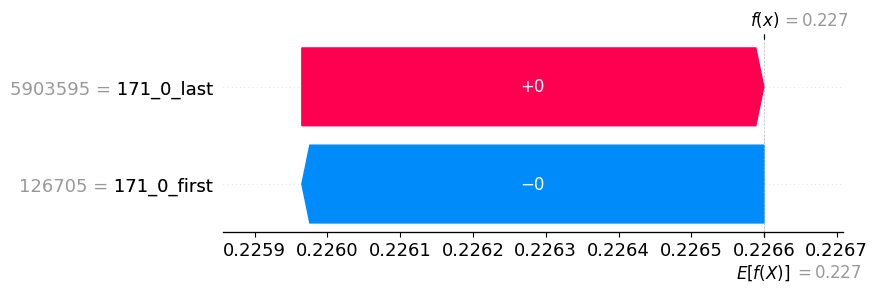

Explaining index 1286


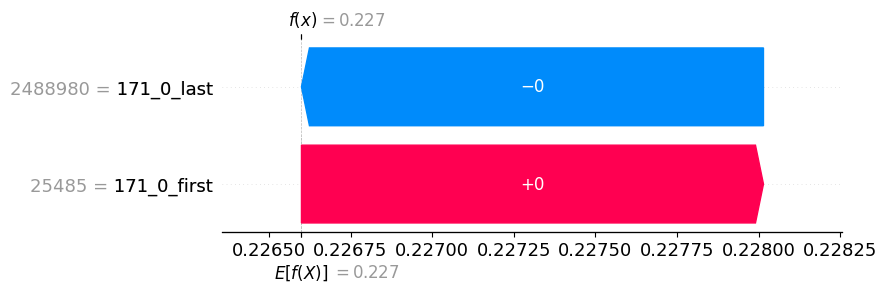

Explaining index 3572


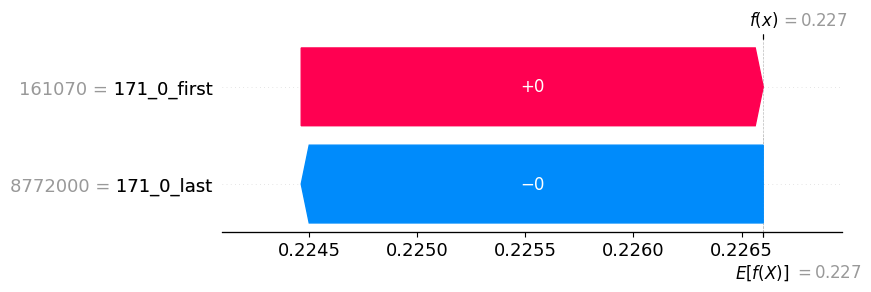


### SHAP explanations for FP cluster 1 ###
Explaining index 600


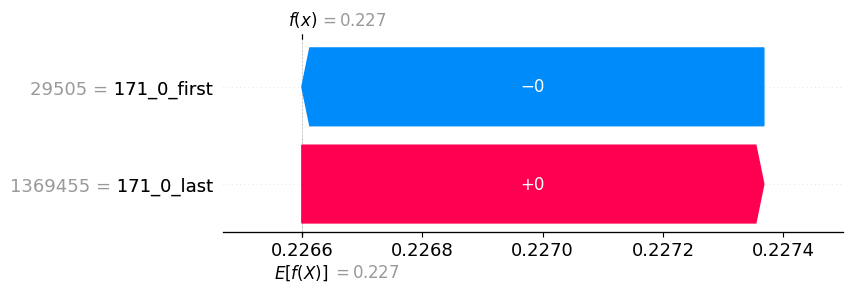

Explaining index 4865


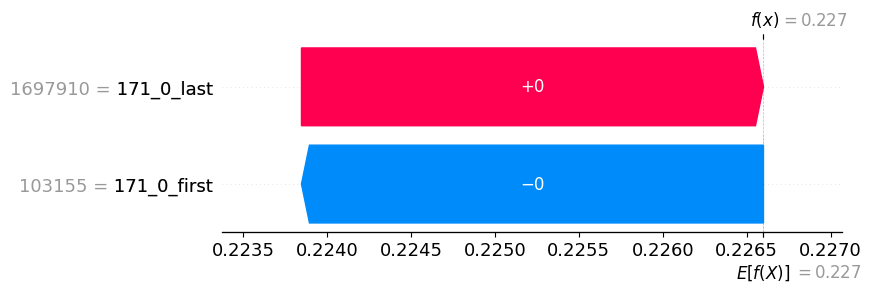

Explaining index 1095


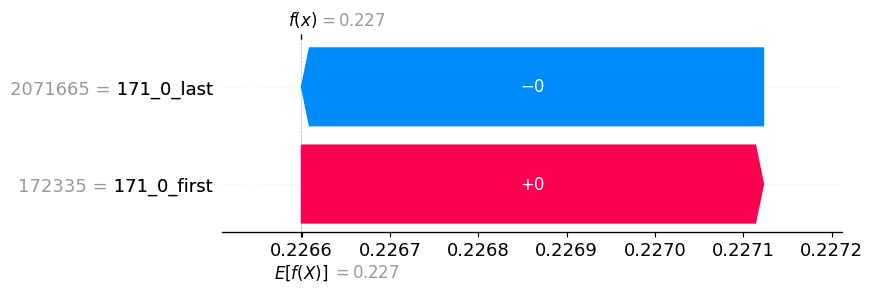


### SHAP explanations for FP cluster 2 ###
Explaining index 108


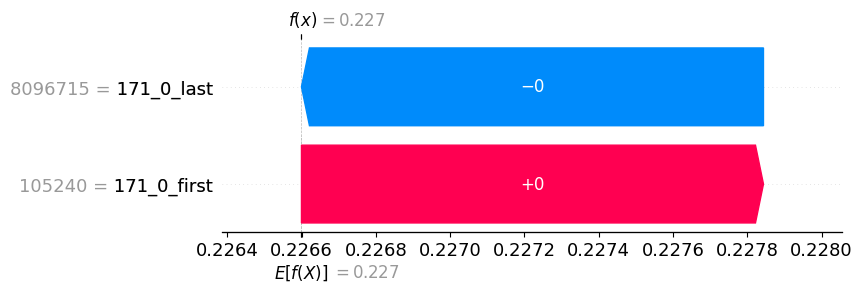

Explaining index 114


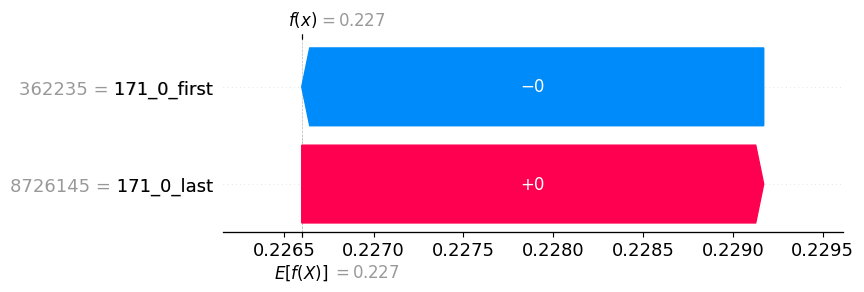

Explaining index 1637


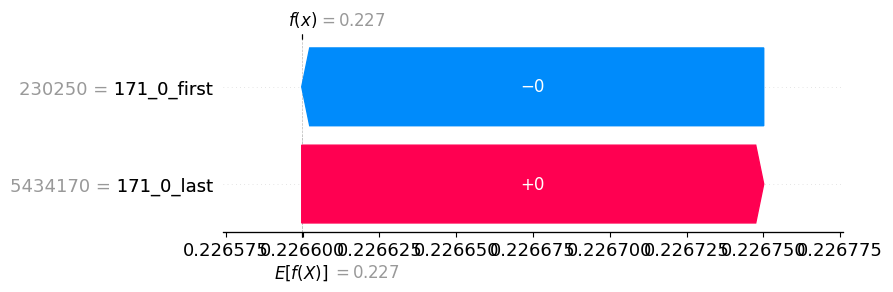

In [30]:
# Run SHAP for each cluster:
for c in samples_per_cluster:
    print(f"\n### SHAP explanations for FP cluster {c} ###")
    for idx in samples_per_cluster[c]:
        print(f"Explaining index {idx}")
        explain_fp_sample(idx)

#### Option B - DBSCAN (density-based, good for outliers)

/tmp/ipykernel_3084/2547284361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp["dbscan_cluster"] = labels_db


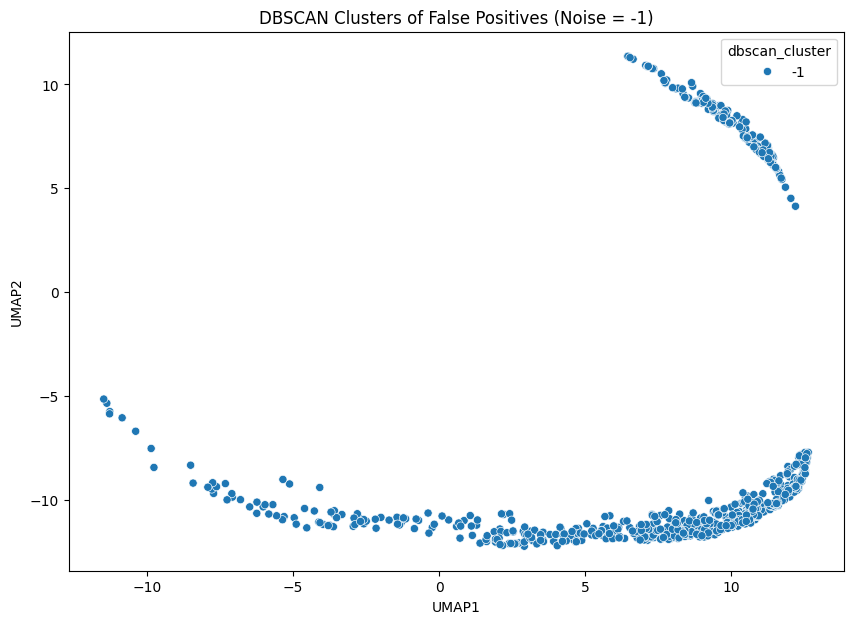

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_fp_imputed)

db = DBSCAN(eps=1.2, min_samples=10).fit(X_scaled)
labels_db = db.labels_  # -1 means outlier

df_fp["dbscan_cluster"] = labels_db

df_umap_fp["dbscan_cluster"] = labels_db

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_umap_fp,
    x="UMAP1",
    y="UMAP2",
    hue="dbscan_cluster",
    palette="tab20",
    s=35
)
plt.title("DBSCAN Clusters of False Positives (Noise = -1)")
plt.show()

### Per-feature statistical contrast: FP vs FN
We do not simply compare all 500+ features - it becomes noise.

1. Find top N important features from XGBoost

2. Compare FP vs FN statistically only on those features

2. Visualize difference with:

    * heatmaps

    * boxplots

    * z-score contrasts

**Step 1. Select top N important features (e.g., N = 20)**

In [13]:
importances = pd.Series(model.feature_importances_, index=feature_cols)
top_n = 20
top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()

top_features

['158_9_max',
 '666_0_last',
 '459_9_max',
 '427_0_slope',
 'Spec_5_Cat3',
 'study_length_time_step',
 'Spec_7_Cat1',
 '167_centroid_mean',
 '397_0_std',
 'Spec_1_Cat1',
 '835_0_slope',
 '459_15_max',
 '158_0_mean',
 '666_0_slope',
 '397_0_mean',
 'Spec_2_Cat5',
 '158_0_std',
 '459_6_max',
 '397_3_max',
 '397_0_max']

**Step 2. Compute group statistics (FP vs FN vs Correct)**

In [14]:
# average raw feature values grouped by FP/FN/Correct
groups = ["FP", "FN", "Correct"]
stats = {}

for g in groups:
    stats[g] = df_err[df_err.error_type == g][top_features].mean()

df_stats = pd.DataFrame(stats)
df_stats

,FP,FN,Correct
158_9_max,3.343265e+06,7.080134e+06,3.632515e+06
666_0_last,2.321912e+05,4.231954e+05,2.964073e+05
459_9_max,1.675560e+04,2.464960e+04,2.157534e+04
427_0_slope,8.566502e+05,1.016754e+06,8.002034e+05
Spec_5_Cat3,5.637255e-02,0.000000e+00,4.606205e-02
study_length_time_step,1.150613e+02,2.089846e+02,2.067861e+02
Spec_7_Cat1,1.801471e-01,2.051282e-01,1.780430e-01
167_centroid_mean,4.421892e+00,4.500700e+00,4.343662e+00
397_0_std,4.368671e+06,7.134316e+06,7.693375e+06
Spec_1_Cat1,5.122549e-01,5.897436e-01,5.696897e-01


**Step 3. Visualize as a heatmap**

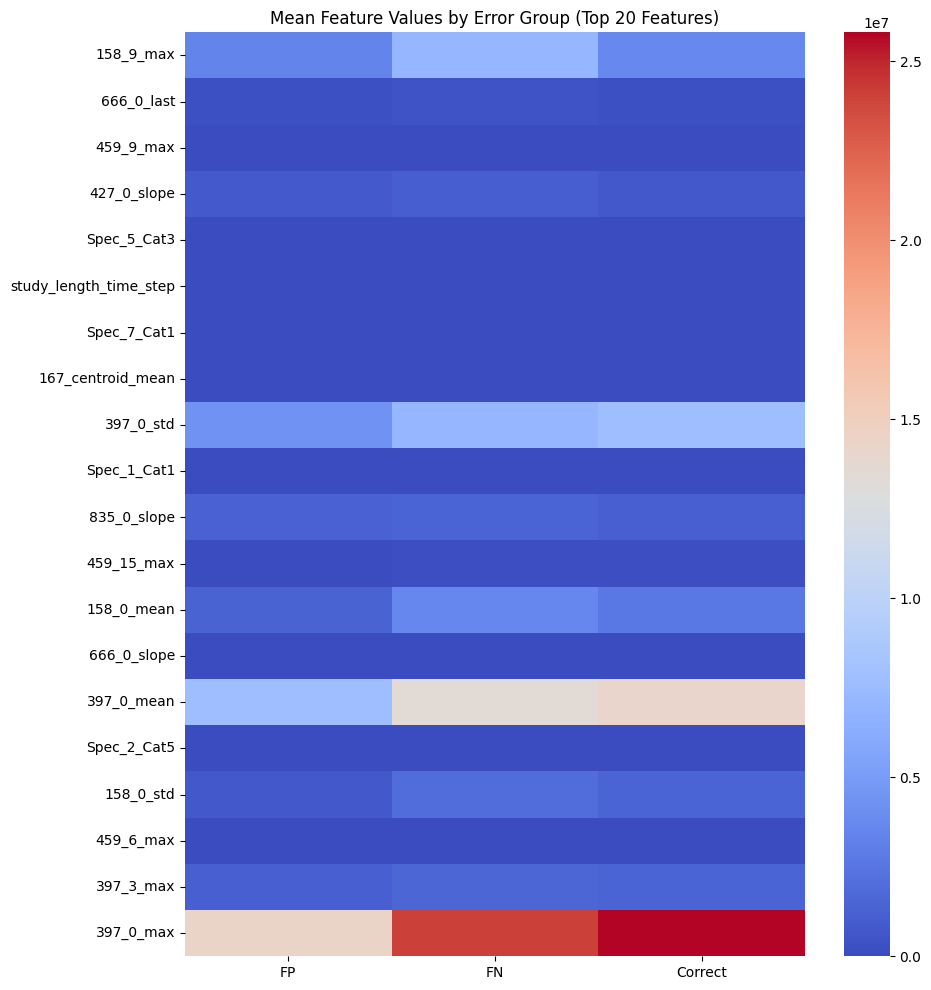

In [15]:
plt.figure(figsize=(10, 12))
sns.heatmap(df_stats, annot=False, cmap="coolwarm")
plt.title("Mean Feature Values by Error Group (Top 20 Features)")
plt.show()

**Step 4. Effect-size metric (not p-values)**

Raw means aren’t enough. Use a simple standardized effect size:

$$
d = \frac{\mu_{\mathrm{FP}} - \mu_{\mathrm{FN}}}{\sigma_{\mathrm{pooled}}}
$$

$$
\sigma_{\mathrm{pooled}} = \sqrt{\frac{\sigma_{\mathrm{FP}}^{2} + \sigma_{\mathrm{FN}}^{2}}{2}}
$$

In [16]:
effect_sizes = {}

for f in top_features:
    fp_vals = df_err[df_err.error_type=="FP"][f]
    fn_vals = df_err[df_err.error_type=="FN"][f]
    
    pooled_std = np.sqrt((fp_vals.var() + fn_vals.var()) / 2)
    
    if pooled_std == 0:
        effect_sizes[f] = 0
    else:
        effect_sizes[f] = (fp_vals.mean() - fn_vals.mean()) / pooled_std

pd.Series(effect_sizes).sort_values(ascending=False)

Spec_2_Cat5               0.361093
Spec_5_Cat3               0.345448
Spec_7_Cat1              -0.062925
666_0_slope              -0.123796
Spec_1_Cat1              -0.155215
397_3_max                -0.221739
167_centroid_mean        -0.308930
835_0_slope              -0.335790
158_9_max                -0.420585
459_6_max                -0.458916
459_9_max                -0.535424
427_0_slope              -0.554543
666_0_last               -0.639753
397_0_std                -0.647925
397_0_max                -0.678642
158_0_mean               -0.687435
158_0_std                -0.688322
397_0_mean               -0.703906
459_15_max               -1.246961
study_length_time_step   -1.424991
dtype: float64

## SHAP explanations for representative FP/FN samples

In [29]:
def make_shap_explainer(model, X_background):
    """
    X_background: a representative subset of X_test, e.g. 100–500 rows.
    Uses model.predict_proba as a callable for SHAP.
    """
    explainer = shap.Explainer(model.predict_proba, X_background)
    return explainer

# Take a small random background sample for SHAP
X_bg = X_test.sample(min(200, len(X_test)), random_state=42)

explainer = make_shap_explainer(model, X_bg)

### Example: SHAP for a single false positive sample

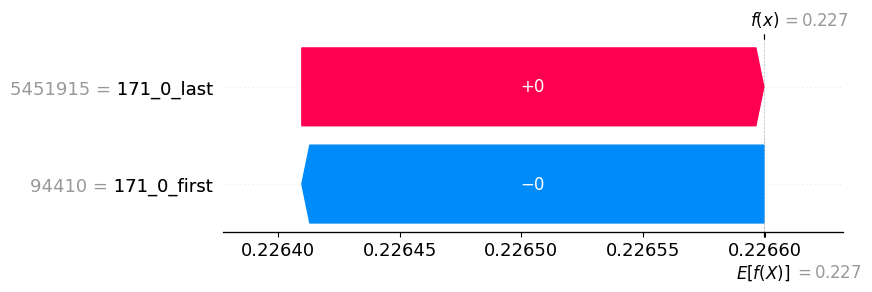

In [29]:
fp_idx = df_err[df_err.error_type == "FP"].index[0]
X_fp = X_test.iloc[[fp_idx]]

n_features = X_fp.shape[1]
max_evals = 2 * n_features + 1

shap_values_fp = explainer(X_fp, max_evals=max_evals)
sv_fp = shap_values_fp[0]

values_fp = sv_fp.values[1]
base_fp = sv_fp.base_values[1]
data_fp = sv_fp.data

sv_fp_class1 = shap.Explanation(
    values=values_fp,
    base_values=base_fp,
    data=data_fp,
    feature_names=X_test.columns
)

shap.plots.waterfall(sv_fp_class1, max_display=20)

### Example: SHAP for a false negative

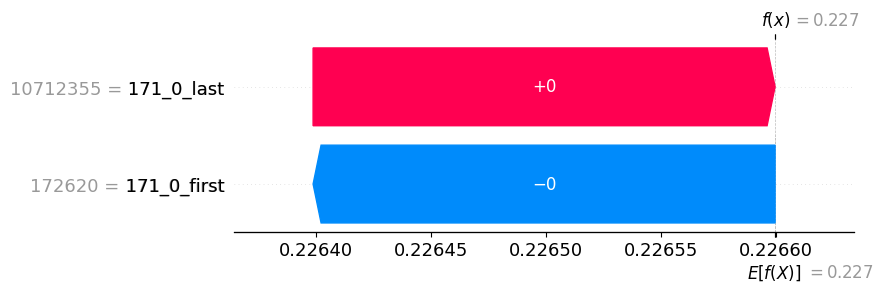

In [28]:
fn_idx = df_err[df_err.error_type == "FN"].index[0]
X_fn = X_test.iloc[[fn_idx]]

n_features = X_fn.shape[1]
max_evals = 2 * n_features + 1  # minimum required

shap_values_fn = explainer(X_fn, max_evals=max_evals)

# Plot
# shap_values_fn is an Explanation with shape (1, 2, n_features) for predict_proba
sv = shap_values_fn[0]          # first (and only) sample -> shape (2, n_features)

# Extract class 1 (failure) contributions
values = sv.values[1]           # shape (n_features,)
base_value = sv.base_values[1]  # scalar for class 1
data = sv.data                  # feature values for this sample

# Build a single-output Explanation to keep waterfall happy
sv_class1 = shap.Explanation(
    values=values,
    base_values=base_value,
    data=data,
    feature_names=X_test.columns
)

# Plot
shap.plots.waterfall(sv_class1, max_display=20)
# if that errors, try:
# shap.waterfall_plot(sv_class1)

## Feature correlation with FP and FN groups

In [31]:
def compute_error_group_feature_stats(df_err, feature_cols):
    stats = {}
    for etype in ["FP", "FN"]:
        subset = df_err[df_err.error_type == etype][feature_cols]
        stats[etype] = subset.mean().sort_values(ascending=False)
    return stats

stats = compute_error_group_feature_stats(df_err, feature_cols)

fp_means = stats["FP"]
fn_means = stats["FN"]

fp_means.head(20)
fn_means.head(20)

397_total_max     5.281296e+08
397_6_max         3.647203e+08
158_total_max     3.513846e+08
835_0_last        2.860454e+08
835_0_delta       2.804599e+08
272_total_max     2.760870e+08
427_0_last        2.068751e+08
427_0_delta       2.027671e+08
272_4_max         1.957178e+08
167_total_max     1.957120e+08
158_total_mean    1.857754e+08
835_0_mean        1.517248e+08
272_total_mean    1.462928e+08
167_5_max         1.228112e+08
397_total_std     1.180923e+08
158_2_max         1.140792e+08
427_0_mean        1.096174e+08
397_total_mean    1.063456e+08
158_total_std     1.046394e+08
272_4_mean        1.043866e+08
dtype: float64

## Outlier detection (Isolation Forest or LOF)
IsolationForest:

* Detects anomalies in high-dimensional data

* Uses random trees to isolate points

* Points that are isolated quickly = outliers

* Points that take more splits to isolate = normal

In [32]:
def detect_outliers(df_err, feature_cols):
    iso = IsolationForest(contamination=0.02, random_state=42)
    preds = iso.fit_predict(df_err[feature_cols])
    df_err["outlier"] = preds # -1 = outlier, 1 = normal
    return df_err

df_err = detect_outliers(df_err, feature_cols)
df_err["outlier"].value_counts()

# Check how many FP/FN are outliers:
pd.crosstab(df_err.error_type, df_err.outlier)

outlier,-1,1
error_type,,
Correct,96,4094
FN,0,39
FP,5,811


**False Negatives (FN)**

* 0 outliers

* 39 normal

* 0.0% outliers

Interpretation:

* FNs are never anomalous in feature space.

* They look normal according to the feature distribution.

* Yet the model predicted them incorrectly.

This means FN occur where:

* Feature values look “in-distribution”

* Model simply fails to catch the failure class for normal-looking data

* The model likely needs different signals/features to catch these cases.

**False Positives (FP)**

* 5 outliers

* 811 normal

* 0.6% outliers

Interpretation:

* Only 5 out of 816 FP are strange in feature space (≈0.6%)

* The vast majority of FP are NOT anomalies

Therefore:

* FPs are not caused by weird, unusual feature values.

* They look very similar to normal cases.

This means:

* The model overpredicts class 1 in regions of feature space that look typical.

* The FP cluster you're analyzing is not composed of feature-space outliers.

**Conclusion**
The model’s errors are not caused by weird or anomalous feature values. Both FP and FN mostly occur among normal, in-distribution samples. FN never appear as outliers, meaning failures often look normal in feature space. FP are also overwhelmingly normal; the model just misclassifies ordinary samples.


## Utility: inspect representative samples

In [33]:
def inspect_samples(df_err, n_fp=5, n_fn=5):
    fp_samples = df_err[df_err.error_type=="FP"].sample(min(n_fp, df_err[df_err.error_type=="FP"].shape[0]))
    fn_samples = df_err[df_err.error_type=="FN"].sample(min(n_fn, df_err[df_err.error_type=="FN"].shape[0]))
    return fp_samples, fn_samples

fp_samples, fn_samples = inspect_samples(df_err, n_fp=5, n_fn=5)

fp_samples
fn_samples

,vehicle_id,171_0_first,171_0_last,171_0_delta,171_0_mean,171_0_std,171_0_slope,171_0_r2,666_0_first,666_0_last,...,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8,y_true,y_proba,y_pred,error_type,outlier
861,5515,84765.0,5895210.0,5810445.0,2.876551e+06,1.676652e+06,27745.896354,0.998198,975.0,94577.0,...,0,0,0,0,0,1,0.388023,0,FN,1
380,2609,4740.0,10739115.0,10734375.0,5.865666e+06,3.279319e+06,42788.992652,0.997174,65.0,880475.0,...,0,0,0,0,0,1,0.482868,0,FN,1
2185,14471,34830.0,4313145.0,4278315.0,2.281300e+06,1.470376e+06,32291.997591,0.998529,585.0,152454.0,...,0,0,0,0,0,1,0.223039,0,FN,1
3632,24362,25680.0,8110410.0,8084730.0,4.274976e+06,2.343111e+06,34196.046579,0.998970,1235.0,487117.0,...,0,0,0,0,0,1,0.119286,0,FN,1
248,1673,222945.0,8818140.0,8595195.0,4.742998e+06,2.544977e+06,32274.579363,0.998807,4186.0,374862.0,...,0,0,0,0,0,1,0.052605,0,FN,1
